# Huawei Research France

## Acrobot RAMP: system identification

### Forecast the state of the altered acrobot system from history and actions

_Balázs Kégl, Gabriel Hurtado, Jianfeng Zhang, Albert Thomas (Huawei Research, Noah's Ark Laboratory, France)_

## Introduction

Can you learn physics using machine learning

### Formal task

You will be given a training multivariate time series ${\cal T} = \big[(o_t, a_t)\big]_{t=1}^T$ of observables $o_t \in \mathbb{R}^6$ and actions $a_t \in \{0, 1, 2\}$. You will need to learn predict the density function of the observables at next step $o_{t+1}$, conditioned on the history:

\begin{equation}
  p\big(o_{t+1} | (o_1, a_1), \ldots, (o_t, a_t)\big)
\end{equation}

You will be evaluated on a test sequence ${\cal T}^\prime = \big[(o_t^\prime, a_t^\prime)\big]_{t=1}^{T^\prime}$ using the likelihood ratio

\begin{equation}
LR({\cal T}^\prime; p) = \frac{\prod_{t=1}^{T^\prime-1} p\big(o^\prime_{t+1} | (o^\prime_1, a^\prime_1), \ldots, (o^\prime_t, a^\prime_t)\big)}{L_\text{b}({\cal T}^\prime)},
\end{equation}

where $L_\text{b}({\cal T}^\prime)$ is a baseline (multivariate spherical Gaussian) likelihood.

${\cal T}$ and ${\cal T}^\prime$ will always come from the same dynamical system. However, to make manual reverse engineering hard, the time series in this public starting kit and the times series on the data challenge server will come from different physics, so your model should be prepared to be transferred to a (slightly) different system. 

### Challenges
1. We do not know whether the system observables $o_t$ and action $a_t$ at time $t$ are sufficient to predict $o_{t+1}$. Therefore we will explicitly ask you to develop (or learn) a feature extractor $f_\text{FE}$ wich will convert the history up to time $t$ into a fixed length state vector $s_t$. Formally,
\begin{equation}
  s_t = f_\text{FE}\big((o_1, a_1), \ldots, (o_t, a_t)\big)
\end{equation}
The predictor will then simplify to
\begin{equation}
  p\big(o_{t+1} | (o_1, a_1), \ldots, (o_t, a_t)\big) = p(o_{t+1} | s_t)
\end{equation}
2. The predictor $p(o_{t+1} | s_t)$ is not a classical regressor outputting a point estimate $\hat{o}_{t+1}$ but a $d$-dimensional density ($d=6$). We needed to find a numerical representation for such a function with two requirements: 1) computationally easy evaluation of the likelihood and 2) computationally easy simulation (sampling). The first trick is that we represent the multivariate density $p(o_{t+1} | s_t)$ by $d$ univariate densities using the chain rule
\begin{equation}
  p(o_{t+1} | s_t) = p_1(o^1_{t+1} | s_t) \prod_{j=2}^d p_j\big(o^j_{t+1} |o^1_{t+1}, \ldots, o^{j-1}_{t+1}, s_t\big), 
\end{equation}
where $o_{t+1} = \big(o^1_{t+1},\ldots,o^d_{t+1}$. This means that you will be asked to learn $d$ (generative) regressors $p_1, \ldots, p_d$.
3. The second trick is that we will represent each generative regressor by a mixture of $L$ ($L < 100$) simple parametric components
\begin{equation}
  p_j\big(o^j_{t+1} |o^1_{t+1}, \ldots, o^{j-1}_{t+1}, s_t\big) = \sum_{\ell=1}^L w_\ell {\cal P}_\ell(o^j_{t+1}; \theta_\ell).
\end{equation}
The $j$th regressor $p_j$ will thus map its vector input $\big(o^1_{t+1}, \ldots, o^{j-1}_{t+1}, s_t\big)$ onto a sequence of weights, densities, and denisty parameters $\big[(w, {\cal P}, \theta)_\ell\big]_{\ell=1}^L$.

This may sound complicated, but in fact it is relatively easy to convert both random forests and neural nets into generative regressors of this kind, and we will provide starting kit examples for you for both of these classes. Also note that the intricacies of training set generation for each regressor will be taken care of the workflow behind the scenes; all you need to do is to parameterize the regressors.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import pandas as pd
import rampwf as rw
import xarray as xr

import altair as alt
alt.renderers.enable('notebook');

You can load `problem.py` to have access the RAMP setup.

In [2]:
problem = rw.utils.assert_read_problem()

## Exploratory data analysis

### Loading the data

Let's load the data. `X_ds` is `xr.Dataset` which is a versatile container. We will not use many features of it so most of the time it will be converted to `pandas.Dataframe`. `y_array` is a numpy array.

In [3]:
X_ds, y_array = problem.get_train_data()
X_ds

<xarray.Dataset>
Dimensions:        (time: 9999)
Coordinates:
  * time           (time) datetime64[ns] 2019-08-05 2019-08-06 ... 2049-02-26
Data variables:
    thetaDot2      (time) float64 -0.06082 0.251 0.4582 ... 0.2294 -0.006333
    cos(theta2)    (time) float64 0.9969 0.9951 0.9852 ... 0.8461 0.8186 0.8029
    sin(theta2)    (time) float64 0.0791 0.09904 0.1716 ... 0.5331 0.5744 0.5961
    thetaDot1      (time) float64 -0.09504 -0.2799 -0.3872 ... -0.6564 -0.9989
    cos(theta1)    (time) float64 0.9977 0.9996 0.9993 ... 0.8672 0.9049 0.9637
    sin(theta1)    (time) float64 0.0681 0.02979 -0.03855 ... 0.4257 0.2671
    action         (time) float64 2.0 2.0 1.0 0.0 0.0 ... 0.0 1.0 1.0 1.0 2.0
    restart        (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    action_extra   (time) float64 2.0 1.0 0.0 0.0 2.0 ... 1.0 1.0 1.0 2.0 0.0
    y_thetaDot2    (time) float64 0.251 0.4582 0.1683 ... -0.006333 -0.2144
    y_cos(theta2)  (time) float64 0.9951 0.9852 0.972 ... 0

`X_ds` is indexed by time. The unit (day) is arbitrary, in reality acrobot is moving much faster. The first six variables are the system observables $o_t \in \mathbb{R}$. For more information, we refer to the [acrobot site](https://gym.openai.com/envs/Acrobot-v1). The semantics of the variables is the same as in the original system, but **we altered the physics that generated the time series to make reverse engineering harder**. Also note that the data in the starting kit and the data in the challenge server were also generated by different physics since we would like you to learn from data not to manually figure out the dynamics and hard code it in your solutions.

`actions` is a ternary action: `0.0` means kick to the left, `1.0` means no kick, `2.0` means kick to the right. Indeed, the change of `thetaDot2` (the angular speed of the second joint) is roughly correlated with the action.

In [12]:
print((X_ds.thetaDot2[1:].values - X_ds.thetaDot2[:-1].values)[X_ds.action[:-1]==0.0].mean())
print((X_ds.thetaDot2[1:].values - X_ds.thetaDot2[:-1].values)[X_ds.action[:-1]==1.0].mean())
print((X_ds.thetaDot2[1:].values - X_ds.thetaDot2[:-1].values)[X_ds.action[:-1]==2.0].mean())

0.013794905781744223
-0.009209155725392056
-0.004300305107948717


`restart` is a binary helper column:  `0.0` means the time step is a continuation of the previous trace, `1.0` means that we start a new trace from a (roughly) vertically hanging starting state. In the public training data there is one restart, meaning that we have two traces. The cross validation will be done by these traces, so in the public training we will have two folds. In the private training data at the challenge server we may have a different number of restarts. The test data can also contain several traces, delineated in the same way.

In [5]:
X_ds.restart.values.sum()

4

`action_extra` TODO why do we need it

The rest of the columns are identical to `y_array`, which is the prediction target. It corresponds to the system observables $o_t$ (first six columns), shifted backwards by one, meaning that the target is to predict the system observable $o_{t+1}$ at time $t+1$. The reason for `X_ds` (the input) containing the target will be clear later.

### Visualizing the data

We now plot the system variables against time. You can explore different segments of training (and test) sets by changing `start_time` and `end_time` (and loading the test set on the top of the file).

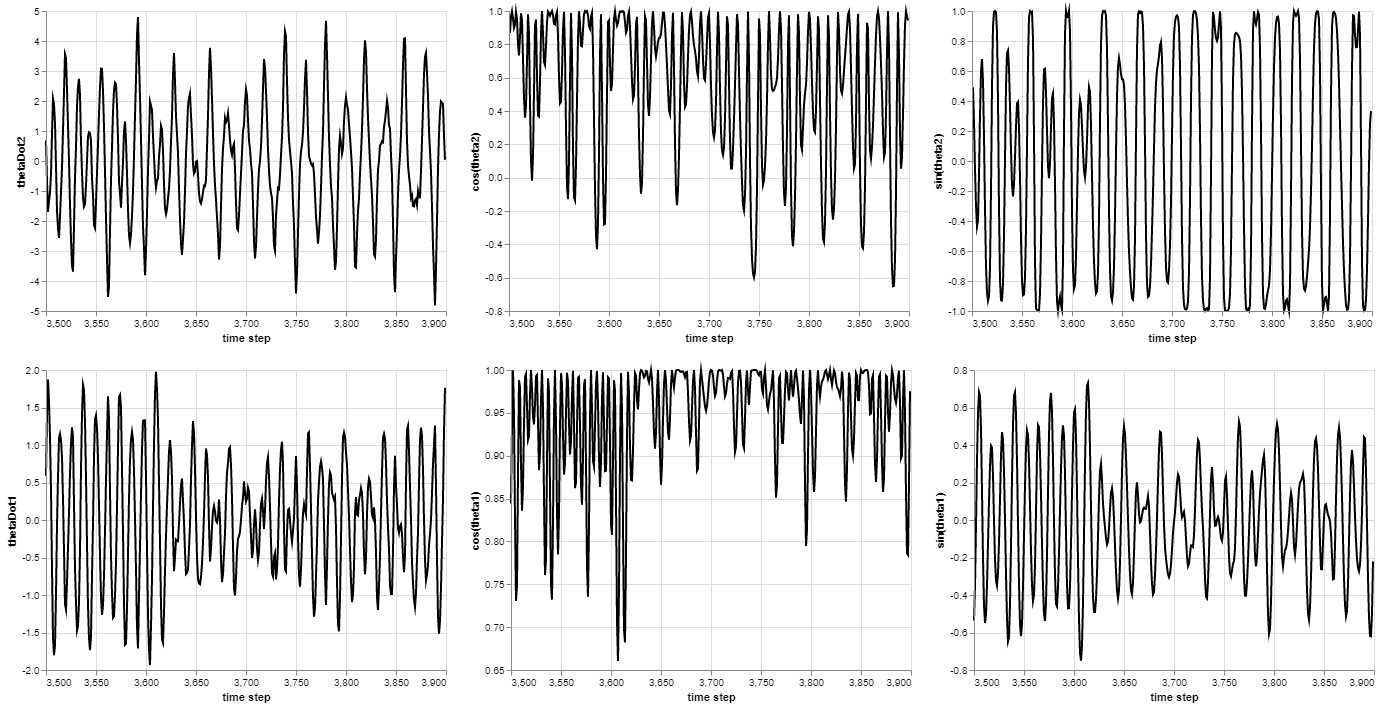

In [8]:
figs = []
start_time = 3500
end_time = 3900
for observable_col in problem._target_column_observation_names:
    ground_truth = X_ds.to_dataframe().reset_index().reset_index()
    line_gt = alt.Chart(ground_truth[start_time:end_time]).mark_line(color='black').encode(
        x=alt.X('index:Q', title='time step'),
        y=alt.Y(observable_col + ':Q', scale=alt.Scale(zero=False)),
    )
    fig = line_gt
    figs.append(fig)
alt.vconcat(alt.hconcat(*figs[:3]), alt.hconcat(*figs[3:]))

## The pipeline: what you need to develop

For submitting at the challenge site, you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor` in `ts_feature_extractor.py`, which will be used to extract features for representing the system state at time $t$. 
* the class `GenerativeRegressor` in `generative_regressor.py` to predict the distribution of the six system variables at time $t+1$ from the features returned by the feature extractor.

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/ts_feature_extractor.py`](/edit/submissions/starting_kit/ts_feature_extractor.py). It receives an xarray Dataset `X_ds` defined at the beginning of the notebook. It should produce a pandas DataFrame containing the extracted features, which will then be used for regression.  

Be careful not to use any information from the future (`X_ds[t + 1:]`) when constructing `X_df[t]`. We have implemented a check for that in the training workflow, but any attempt to purposefully work around those checks may lead to disqualification from the challenge.

The following simple feature extractor in the starting kit simply makes $s_t = (o_t, a_t)$.

In [ ]:
# %load submissions/starting_kit/ts_feature_extractor.py
class FeatureExtractor():
    def __init__(self, restart_name):
        """
        Parameters
        ----------
        restart_name : str
            The name of the 0/1 column indicating restarts in the time series.
        """
        self.restart_name = restart_name

    def transform(self, X_ds):
        """Transform time series into list of states.
        We simply use the observables at time t as the state.
        Be careful not to use any information from the future (X_ds[t + 1:])
        when constructing X_df[t].
        Parameters
        ----------
        X_ds : xarray.Dataset
            The raw time series.
        Return
        ------
        X_df : pandas Dataframe
            The list of states.
        """
        X_df = X_ds.to_dataframe()
        # Since we do not use the restart information in our regressor, we
        # remove it
        restart = X_df[self.restart_name].values
        X_df = X_df.drop(columns=self.restart_name)
        return X_df

### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [10]:
%%file submissions/starting_kit/classifier.py
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = Pipeline([
            ('imputer', Imputer(strategy='median')),
            ('classifier', LogisticRegression(C=1.))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



Overwriting submissions/starting_kit/classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `classifier.py` and `feature_extractor.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [11]:
!ramp_test_submission

Testing Titanic survival classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train auc = 0.84
	valid auc = 0.89
	test auc = 0.83
	train acc = 0.8
	valid acc = 0.85
	test acc = 0.76
	train nll = 0.46
	valid nll = 0.39
	test nll = 0.5
CV fold 1
	train auc = 0.85
	valid auc = 0.86
	test auc = 0.83
	train acc = 0.81
	valid acc = 0.8
	test acc = 0.76
	train nll = 0.44
	valid nll = 0.45
	test nll = 0.49
CV fold 2
	train auc = 0.85
	valid auc = 0.83
	test auc = 0.82
	train acc = 0.81
	valid acc = 0.79
	test acc = 0.76
	train nll = 0.44
	valid nll = 0.47
	test nll = 0.5
CV fold 3
	train auc = 0.84
	valid auc = 0.91
	test auc = 0.83
	train acc = 0.8
	valid acc = 0.82
	test acc = 0.76
	train nll = 0.46
	valid nll = 0.4
	test nll = 0.5
CV fold 4
	train auc = 0.85
	valid auc = 0.87
	test auc = 0.83
	train acc = 0.81
	valid acc = 0.81
	test acc = 0.76
	train nll = 0.45
	valid nll = 0.44
	test nll = 0.51
CV fold 5
	train auc =

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [titanic](http://www.ramp.studio/events/titanic) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/titanic/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/titanic/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/titanic/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/titanic/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train auc = 0.85 ± 0.005
train acc = 0.81 ± 0.006
train nll = 0.45 ± 0.007
valid auc = 0.87 ± 0.023
valid acc = 0.81 ± 0.02
valid nll = 0.44 ± 0.024
test auc = 0.83 ± 0.006
test acc = 0.76 ± 0.003
test nll = 0.5 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/titanic/leaderboard)) is area under the roc curve ("auc"), so the line that is relevant in the output of `ramp_test_submission` is `valid auc = 0.87 ± 0.023`. When the score is good enough, you can submit it at the RAMP.

## Other models in the starting kit

You can also keep several other submissions in your work directory [`submissions`](/tree/submissions). [`random_forest_20_5`](/tree/submissions/random_forest_20_5) uses the same feature extractor as [`starting_kit`](/tree/submissions/starting_kit) but another classifier.

In [12]:
%%file submissions/random_forest_20_5/feature_extractor.py
import pandas as pd


class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_df_new = pd.concat(
            [X_df.get(['Fare', 'Age', 'SibSp', 'Parch']),
             pd.get_dummies(X_df.Sex, prefix='Sex', drop_first=True),
             pd.get_dummies(X_df.Pclass, prefix='Pclass', drop_first=True),
             pd.get_dummies(
                 X_df.Embarked, prefix='Embarked', drop_first=True)],
            axis=1)
        X_df_new = X_df_new.fillna(-1)
        XX = X_df_new.values
        return XX



Overwriting submissions/random_forest_20_5/feature_extractor.py


In [13]:
%%file submissions/random_forest_20_5/classifier.py
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = Pipeline([
            ('imputer', Imputer(strategy='median')),
            ('classifier', LogisticRegression(C=1.0))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



Overwriting submissions/random_forest_20_5/classifier.py


You can train this by specifying the subfolder in the test script.

In [14]:
!ramp_test_submission --submission random_forest_20_5

Testing Titanic survival classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/random_forest_20_5 ...
CV fold 0
	train auc = 0.84
	valid auc = 0.89
	test auc = 0.83
	train acc = 0.8
	valid acc = 0.85
	test acc = 0.76
	train nll = 0.46
	valid nll = 0.39
	test nll = 0.5
CV fold 1
	train auc = 0.85
	valid auc = 0.86
	test auc = 0.83
	train acc = 0.81
	valid acc = 0.8
	test acc = 0.76
	train nll = 0.44
	valid nll = 0.45
	test nll = 0.49
CV fold 2
	train auc = 0.85
	valid auc = 0.83
	test auc = 0.82
	train acc = 0.81
	valid acc = 0.79
	test acc = 0.76
	train nll = 0.44
	valid nll = 0.47
	test nll = 0.5
CV fold 3
	train auc = 0.84
	valid auc = 0.91
	test auc = 0.83
	train acc = 0.8
	valid acc = 0.82
	test acc = 0.76
	train nll = 0.46
	valid nll = 0.4
	test nll = 0.5
CV fold 4
	train auc = 0.85
	valid auc = 0.87
	test auc = 0.83
	train acc = 0.81
	valid acc = 0.81
	test acc = 0.76
	train nll = 0.45
	valid nll = 0.44
	test nll = 0.51
CV fold 5
	train

## Working in the notebook

When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly, or even deconstruct the code from [ramp-workflow](https://github.com/paris-saclay-cds/ramp-workflow).

In [52]:
import imp
problem = imp.load_source('', 'problem.py')

Get the training data.

In [53]:
X_train, y_train = problem.get_train_data()

Get the first cv fold, creating training and validation indices.

In [54]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]
test_is

array([319, 289, 567, 294, 112, 216, 186, 195, 478, 531, 451, 282,  43,
       189, 177, 159, 342, 513, 514, 215, 431, 132, 139, 233, 136, 237,
       111, 271, 354,  61, 427, 149, 523, 475, 376, 328, 419, 546,   4,
        83,  75,   5, 516,  81, 301, 500, 562, 309, 318, 473, 307, 207,
       346, 297, 404, 146, 119, 209, 158, 460,  34, 183, 131, 272,  21,
       461, 125, 400, 138, 173, 247, 549, 334, 483, 432,   9, 316, 528,
       193, 445, 167, 179, 252, 229, 517, 504, 364, 539,  82, 331, 181,
       240,  26, 424, 457, 392, 150, 226,  27, 340, 230, 178, 446,   7,
        47, 332, 208, 390, 557, 377, 256, 227, 262, 352])

Train your starting kit.

In [55]:
fe, clf = problem.workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, train_is)

Get the full prediction (train and validation).

In [56]:
y_pred = problem.workflow.test_submission((fe, clf), X_train)

Print the training and validation scores.

In [57]:
score_function = problem.score_types[0]

`score_function` is callable, wrapping scikit-learn's `roc_auc_score`. It expects a 0/1 vector as ground truth (since out labels are 0 and 1, `y_train` can be passed as is), and a 1D vector of predicted probabilities of class '1', which means we need the second column of `y_pred`.

In [58]:
score_train = score_function(y_train[train_is], y_pred[:, 1][train_is])
print(score_train)

0.84298842199


In [59]:
score_valid = score_function(y_train[test_is], y_pred[:, 1][test_is])
print(score_valid)

0.887278582931


You can check that it is just a wrapper of `roc_auc_score`.

In [60]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train[train_is], y_pred[:, 1][train_is]))

0.84298842199


Get the independent test data.

In [61]:
X_test, y_test = problem.get_test_data()

Test the submission on it.

In [28]:
y_test_pred = problem.workflow.test_submission((fe, clf), X_test)

In [30]:
score_test = score_function(y_test, y_test_pred[:, 1])
print(score_test)

0.827582728006


If you want to execute training step by step, go to the [`feature_extractor_classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor_classifier.py), [`feature_extractor`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor.py), and [`classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/classifier.py) workflows and deconstruct them.

First load the submission files and instantiate the feature extractor and regressor objects.

In [32]:
feature_extractor = imp.load_source(
    '', 'submissions/starting_kit/feature_extractor.py')
fe = feature_extractor.FeatureExtractor()
classifier = imp.load_source(
    '', 'submissions/starting_kit/classifier.py')
clf = classifier.Classifier()

Select the training folds.

In [42]:
X_train_train_df = X_train.iloc[train_is]
y_train_train = y_train[train_is]

Fit the feature extractor.

In [43]:
fe.fit(X_train_train_df, y_train_train)

Transform the training dataframe into numpy array.

In [44]:
X_train_train_array = fe.transform(X_train_train_df)

Fit the classifier.

In [46]:
clf.fit(X_train_train_array, y_train_train)

Transform the _whole_ (training + validation) dataframe into a numpy array and compute the prediction.

In [49]:
X_train_array = fe.transform(X_train)
y_pred = clf.predict_proba(X_train_array)

Print the errors.

In [50]:
score_train = score_function(y_train[train_is], y_pred[:, 1][train_is])
print(score_train)

0.84298842199


In [51]:
score_valid = score_function(y_train[test_is], y_pred[:, 1][test_is])
print(score_valid)

0.887278582931


## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=titanic notebook).